In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/omdena_project/cp.zip"

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os,shutil,json
import glob
import torch.utils.data
import math
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageDraw
import pandas as pd
import random
from skimage import io, transform
from PIL import Image
import torchvision as vision
from torchvision import transforms, datasets
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [ ]:
def prepare_dataset(dataset_path):
  """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.
    
    returns: 
        train_loader: train loader with batch size of 64
        validation_loader: validation loader with batch size of 128
        
    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

  labels = os.listdir(dataset_path)
  
  # Here images are resized and converted to grayscale so that we have data consistency for other tasks
  dataset = ImageFolder(
      dataset_path,
      transforms.Compose([transforms.Resize((100,100)),
                         transforms.ToTensor()
                        #  ,transforms.Grayscale(num_output_channels=1)
                         ])
  )

  # Validation split 15%
  val_split = int(len(dataset)*0.20)
  train_split = len(dataset) - val_split

  train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

  # to make sure the split is right.
  assert (len(train_dataset)+len(val_dataset)) == len(dataset)

  train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_dataset, 128) 

  return (train_loader, validation_loader)

In [ ]:
dataset_dir = "/content/cropped_img" # Dataset folder path
train_loader, validation_loader = prepare_dataset(dataset_dir)

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms, datasets

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):

        self.classnames=["cat", "dog"]   # Class List
        self.root_dir = root_dir         # Train or Test
        self.img_label_tuple = []        # Data list

        # Loop to extract image path and label for folder name
        for i in range(0, len(self.classnames)):
            class_dir = os.path.join(root_dir, self.classnames[i])
            all_files = [os.path.join(class_dir,f) for f in listdir(class_dir) if isfile(join(class_dir, f))]
            for j in all_files:
              item = tuple((j, i))
              self.img_label_tuple.append(item)

        # Simple transform
        self.transform = transforms.Compose([transforms.Resize((32,32)),
                                              transforms.ToTensor()])

    def __len__(self):
        # Returns lenght of the dataset.
        return len(self.img_label_tuple)

    # Contructur to process dataset, tranform it and returns (input image with label)
    def __getitem__(self, idx):
        path = self.img_label_tuple[idx][0]
        class_id = self.classnames.index(img_label_tuple[idx][1])
        img = Image.open(self.img_label_tuple[idx]).convert('RGB')
        img = self.transform(img)
    
        return (img, class_id)

# Model

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_1', pretrained=True)

feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_ft = model
set_parameter_requires_grad(model_ft, feature_extract)

model_ft.classifier = nn.Sequential(
    nn.Conv2d(512, 256, kernel_size=(1), stride=(1,1)),
    nn.Conv2d(256, 128, kernel_size=(1,1), stride=(1,1)),
    nn.Conv2d(128, 16, kernel_size=(1,1), stride=(1,1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [ ]:

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  model = model_ft.cuda()
  criterion = criterion.cuda()
  optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
	

Tesla P100-PCIE-16GB


In [ ]:
# %%time
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
# best_valid_loss is defined so as to save the best validation loss which is lowest one.
    best_valid_loss = float('Inf')

    print("Training Started !!!")
    for i in range(50):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        model.train()
        for features, labels in train_loader:
          # Label and features assigning
          features, labels = Variable(features.cuda()), Variable(labels.cuda())
          optimizer.zero_grad()

          # Output collection from model
          outputs = model(features.float())
          # Loss calculation and updation
          losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
          losss.backward()
          optimizer.step()
          
          
          training_loss += losss.item()
          # Prediction
          _, pred = torch.max(outputs, 1)
          ttotal+= labels.reshape(-1).size(0)
          tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

        # Validation step starts from here.
        validation_loss = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for features, labels in validation_loader:
            # Label and features assigning
            features, labels = Variable(features.cuda()), Variable(labels.cuda())

            # Output collection from model
            outputs = model(features.float())

            # Loss calculation, here we skip the backward and 
            # optimizer step as we do not update weights while validating a model
            loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
            # Prediction
            _, pred = torch.max(outputs, 1)
            total+= labels.reshape(-1).size(0)
            correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            validation_loss += loss.item()


        train_loss_list.append(training_loss/len(train_loader))
        val_loss_list.append(validation_loss/len(validation_loader))
        epc_list.append(i)
        train_acc_list.append(100*(tcorrect/ttotal))
        val_acc_list.append(100*(correct/total))

        # Logic was defined so as to save the weights of mnist_model when validation loss is lowest.
        # if best_valid_loss > validation_loss:
        #     best_valid_loss = validation_loss 
        #     # Saving Best Pre-Trained Model as .pth file
        #     torch.save(model, ".pth")

        print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
        print("Validation loss: {}".format( validation_loss/len(validation_loader)))
        print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
        print("Validation Accuracy: {}".format(100*(correct/total)))

train()

print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 0.6261580429780178
Validation loss: 0.3332939147949219
Trainig Accuracy: 81.20980707395499
Validation Accuracy: 89.46945337620579
Epoch 2 - 
Traning loss: 0.2835568669132697
Validation loss: 0.3098901376128197
Trainig Accuracy: 90.71543408360128
Validation Accuracy: 89.22829581993568
Epoch 3 - 
Traning loss: 0.23265873038998017
Validation loss: 0.25489291697740557
Trainig Accuracy: 92.36334405144694
Validation Accuracy: 90.83601286173634
Epoch 4 - 
Traning loss: 0.21238636053525484
Validation loss: 0.23952199816703795
Trainig Accuracy: 92.56430868167203
Validation Accuracy: 91.63987138263666
Epoch 5 - 
Traning loss: 0.17759562398378664
Validation loss: 0.2744129568338394
Trainig Accuracy: 93.75
Validation Accuracy: 91.2379421221865
Epoch 6 - 
Traning loss: 0.18565907319768882
Validation loss: 0.23044138327240943
Trainig Accuracy: 93.72990353697749
Validation Accuracy: 92.68488745980707
Epoch 7 - 
Traning loss: 0.1563718089212974
Validation 

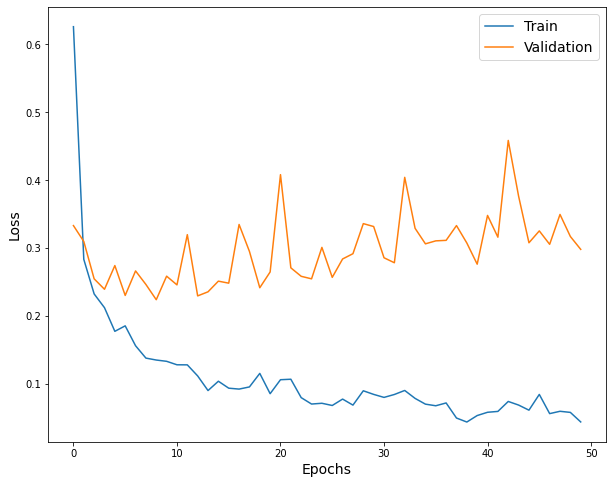

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(train_loss_list))
plt.figure(figsize=(10, 8))
plt.plot(ep, train_loss_list, label='Train')
plt.plot(ep, val_loss_list, label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("")
plt.legend(fontsize=14)
plt.show()

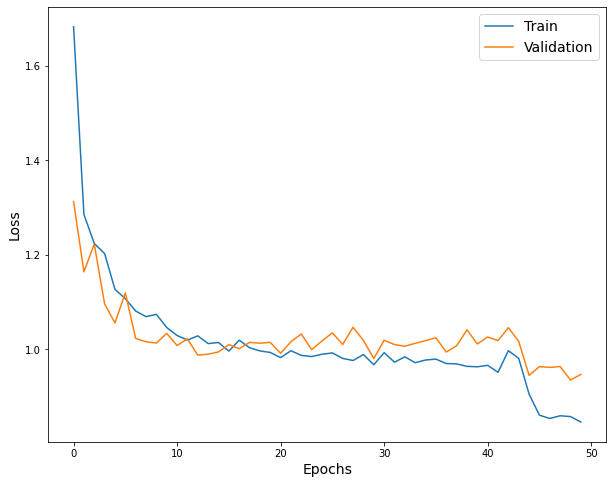

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(train_loss_list))
plt.figure(figsize=(10, 8))
plt.plot(ep, train_loss_list, label='Train')
plt.plot(ep, val_loss_list, label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("")
plt.legend(fontsize=14)
plt.show()

In [ ]:
validation_loss = 0
correct = 0
total = 0
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
  for features, labels in validation_loader:
    # Label and features assigning
    features, labels = Variable(features.cuda()), Variable(labels.cuda())

    # Output collection from model
    outputs = model(features.float())

    # Loss calculation, here we skip the backward and 
    # optimizer step as we do not update weights while validating a model
    loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
    # Prediction
    _, pred = torch.max(outputs, 1)
    y_pred.extend(pred.detach().cpu().numpy())
    y_true.extend(labels.detach().cpu().numpy())
    total+= labels.reshape(-1).size(0)
    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
    validation_loss += loss.item()

In [ ]:
cls = ['Actuator', 'Concentric', 'Inside text', 'Instrument', 'Unidentified', 'connector', 'engine', 'flange', 'flange_blind', 
                         'flow_direction', 'line_break', 'plug', 'separator', 'tank_vessel', 'text', 'valve']

In [ ]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [ ]:
set(y_pred)

{0, 1, 2, 4, 7, 8, 10, 11, 14, 15}

In [ ]:
set(y_true)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0      0.625     1.000     0.769         5
           1      1.000     1.000     1.000        12
           2      0.897     0.858     0.877       233
           3      1.000     0.986     0.993        69
           4      0.800     0.800     0.800        50
           5      1.000     1.000     1.000         5
           6      1.000     1.000     1.000         1
           7      0.929     0.942     0.935        69
           8      0.500     0.500     0.500         2
           9      0.994     0.994     0.994       168
          10      0.955     0.913     0.933        46
          11      0.875     1.000     0.933         7
          12      1.000     1.000     1.000         3
          13      0.000     0.000     0.000         1
          14      0.935     0.951     0.943       514
          15      0.966     0.949     0.957        59

    accuracy                          0.933      1244
   macro avg      0.842   

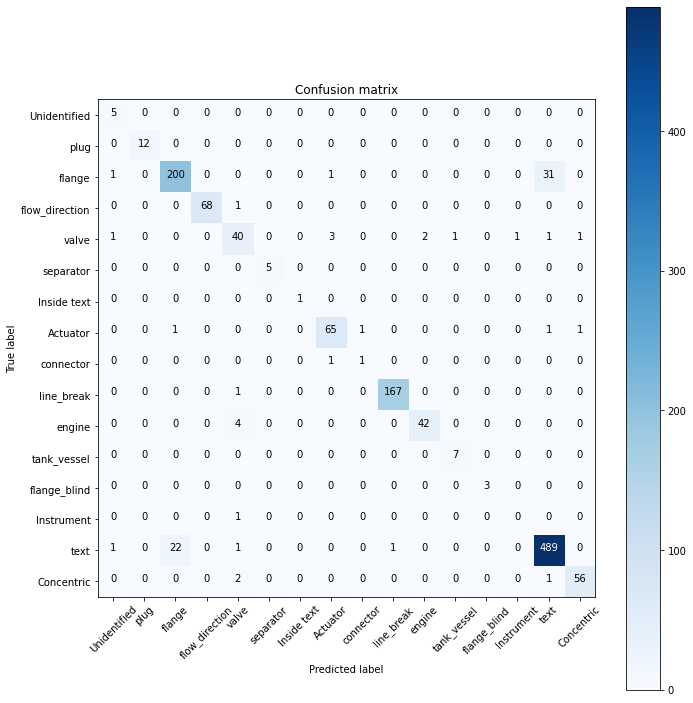

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

classes = ['Actuator', 'Concentric', 'Inside text', 'Instrument', 'Unidentified', 'connector', 'engine', 'flange', 'flange_blind', 
                         'flow_direction', 'line_break', 'plug', 'separator', 'tank_vessel', 'text', 'valve']
# classes = ('Low', 'Medium', 'High', "Severe")
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(metrics.classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(10,10))
plot_confusion_matrix(cf_matrix, set(classes))

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [ ]:
image_path_in_colab = "/content/croped_img/text/text_1420.png_1000.jpg"
# extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))


In [ ]:
print(extractedInformation)

In [ ]:
pip install easyocr

In [ ]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext("/content/croped_img/text/text_1420.png_1036.jpg")
result

[([[0, 0], [177, 0], [177, 31], [0, 31]], 'PR_004-S', 0.5228209614100789)]

In [ ]:
result = reader.readtext("/content/croped_img/text/text_1420.png_1037.jpg")
result

[([[0, 0], [167, 0], [167, 30], [0, 30]], 'ANOMAUF', 0.5442980347189178),
 ([[181, 0], [244, 0], [244, 30], [181, 30]], 'FSD', 0.6217138274374273)]

In [ ]:
result = reader.readtext("/content/croped_img/text/text_1420.png_1038.jpg")
result

[([[0, 0], [69, 0], [69, 31], [0, 31]], 'APS', 0.999843079474457),
 ([[87, 0], [150, 0], [150, 31], [87, 31]], '50U', 0.4884205090127278)]

In [ ]:
pip install keras-ocr


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Looking for /root/.keras-ocr/crnn_kurapan.h5


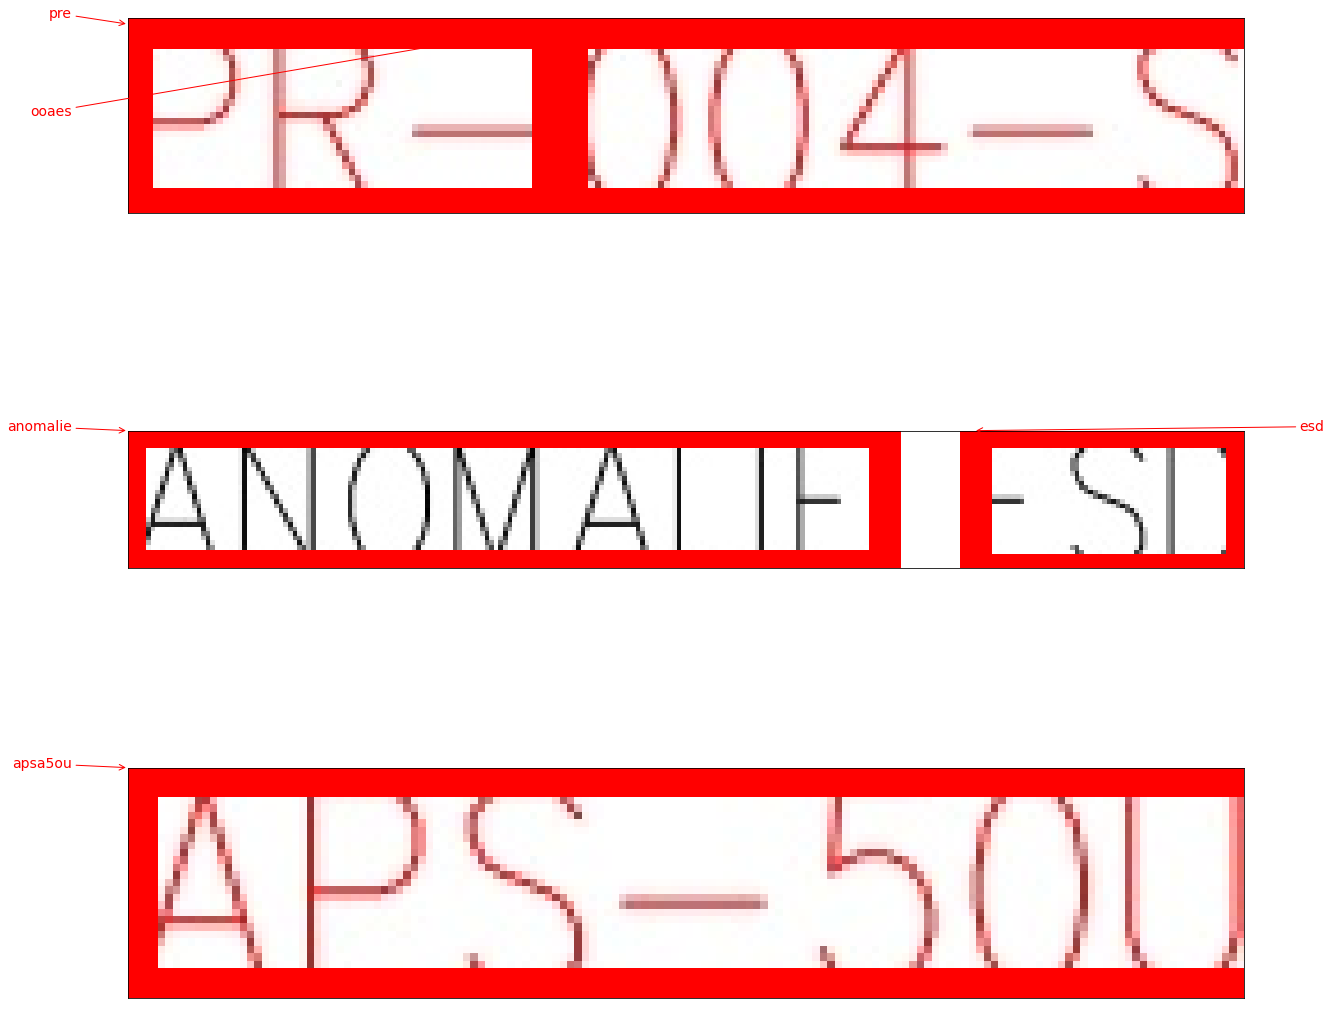

In [ ]:
import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [
    keras_ocr.tools.read(url) for url in [
        '/content/croped_img/text/text_1420.png_1036.jpg',
        '/content/croped_img/text/text_1420.png_1037.jpg',
        '/content/croped_img/text/text_1420.png_1038.jpg'
    ]
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)